In [19]:
from astropy.table import Table
import numpy as np
from matplotlib import pyplot as plt

import orpheus

In [20]:
savepath_SLICS = "/vol/euclidraid4/data/lporth/HigherOrderLensing/Mocks/SLICS_KiDS450/"
nthreads=48
fthin=1
frac_covs = [0.0,0.01,0.5,0.7,1.0]


['x_arcmin', 'y_arcmin', 'z_spectroscopic', 'z_photometric', 'shear1', 'shear2', 'eps_obs1', 'eps_obs2']


(array([1012677., 1389903.,  668221.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

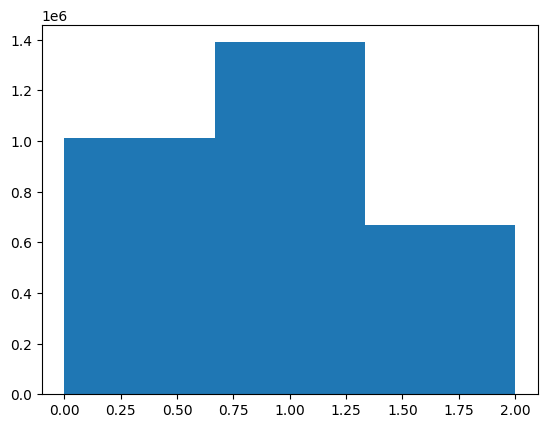

In [34]:
nbinsz = 3
slicscat = Table.read(savepath_SLICS+"GalCatalog_LOS1.fits")
zbins = (slicscat['z_spectroscopic']/0.5).astype(int).data
zbins[zbins>(nbinsz-1)] = nbinsz-1
print(slicscat.keys())
plt.hist(zbins,bins=nbinsz)

In [35]:
shapecat = orpheus.SpinTracerCatalog(spin=2,
                                     pos1=slicscat["x_arcmin"],
                                     pos2=slicscat["y_arcmin"],
                                     zbins=zbins,
                                     tracer_1=slicscat["shear1"],
                                     tracer_2=slicscat["shear2"])

In [36]:
shapecat.create_mask(method="Basic", pixsize=0.3)

In [37]:
%%time
direct = orpheus.Direct_MapnEqual(order_max=7, Rmin=1., Rmax=32., binsize=0.3, nthreads=nthreads, 
                                  filter_form="C02", frac_covs=frac_covs,
                                  accuracies=1., method="Discrete", ap_weights="InvShot")
mapn = direct.process(shapecat,dotomo=True)

Done 12/12 aperture radiiCPU times: user 5min 8s, sys: 568 ms, total: 5min 8s
Wall time: 11.8 s


In [38]:
mapn[0].shape

(12, 5, 119)

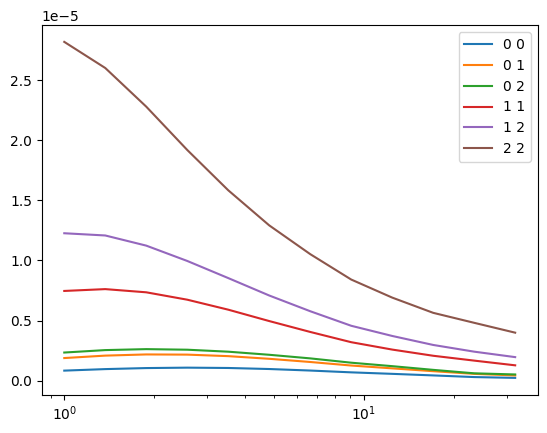

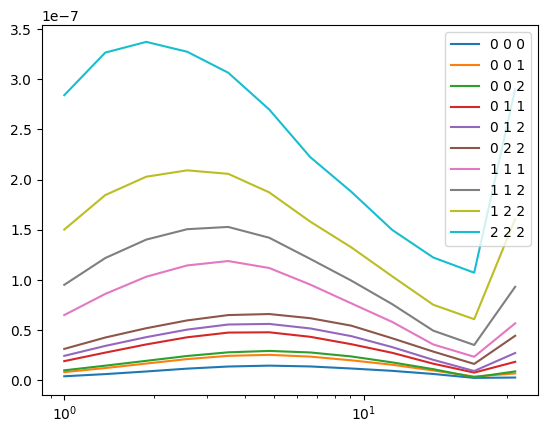

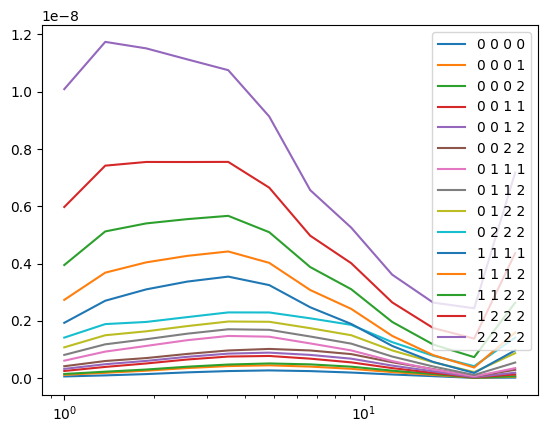

In [44]:
# Order = 2
for z1 in range(nbinsz):
    for z2 in range(z1,nbinsz):
        zcombi = direct.genzcombi([z1,z2])
        plt.semilogx(direct.radii, mapn[0][:,0,direct.genzcombi([z1,z2])],label='%i %i'%(z1,z2))
plt.legend()
plt.show()

# Order = 3
for z1 in range(nbinsz):
    for z2 in range(z1,nbinsz):
        for z3 in range(z2,nbinsz):
            zcombi = direct.genzcombi([z1,z2,z3])
            plt.semilogx(direct.radii, direct.radii*mapn[0][:,0,direct.genzcombi([z1,z2,z3])],label='%i %i %i'%(z1,z2,z3))
plt.legend()
plt.show()

# Order = 4
for z1 in range(nbinsz):
    for z2 in range(z1,nbinsz):
        for z3 in range(z2,nbinsz):
            for z4 in range(z3,nbinsz):
                _full = mapn[0][:,0,direct.genzcombi([z1,z2,z3,z4])]
                _disc = (mapn[0][:,0,direct.genzcombi([z1,z2])] * mapn[0][:,0,direct.genzcombi([z3,z4])] + 
                        mapn[0][:,0,direct.genzcombi([z1,z3])] * mapn[0][:,0,direct.genzcombi([z2,z4])] + 
                        mapn[0][:,0,direct.genzcombi([z1,z4])] * mapn[0][:,0,direct.genzcombi([z2,z3])])
                plt.semilogx(direct.radii, direct.radii**1.5*(_full-_disc),label='%i %i %i %i'%(z1,z2,z3,z4))
plt.legend()
plt.show()

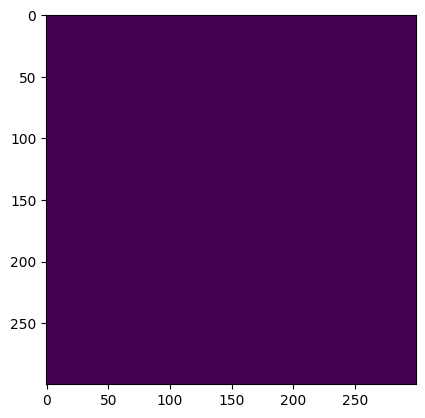

In [57]:
shapecat = orpheus.SpinTracerCatalog(spin=2,
                                     pos1=slicscat["x_arcmin"],
                                     pos2=slicscat["y_arcmin"],
                                     zbins=zbins,
                                     tracer_1=slicscat["shear1"],
                                     tracer_2=slicscat["shear2"])
shapecat.create_mask(method='Basic',pixsize=2.,apply=False)
shapecat.create_mask(method='Random',pixsize=1.,apply=True) # Todo
plt.imshow(shapecat.mask.data)

In [ ]:
mapdirect.getmap(indR=5,cat=shapecat)

In [13]:
%%time
second = orpheus.GGCorrelation(min_sep=0.02, max_sep=200., binsize=0.1, nthreads=nthreads,
                               rmin_pixsize=5, resoshift_leafs=0, shuffle_pix=0, tree_resos=[0,0.25,0.5,1.,2.])
second.process(shapecat, dotomo=False, do_dc=False)
map2s_fromnpcf = second.computeMap2(direct.radii)

Done 96.37 per cent96 per cente 19.95 per centcentper cent.63 per centCPU times: user 1min 28s, sys: 315 ms, total: 1min 29s
Wall time: 4.59 s


In [11]:
%%time
import treecorr
treecorr_cat = treecorr.Catalog(x=shapecat.pos1, y=shapecat.pos2, 
                                g1=shapecat.tracer_1, g2=shapecat.tracer_2)
treecorr_second = treecorr.GGCorrelation(min_sep=second.min_sep, max_sep=second.max_sep,
                                         bin_size=second.binsize,
                                         bin_slop=1., angle_slop=0.5, num_threads=nthreads)
treecorr_second.process(treecorr_cat)
treecorr_map2 = treecorr_second.calculateMapSq(R=direct.radii, m2_uform="Crittenden")

CPU times: user 51.4 s, sys: 7.45 s, total: 58.8 s
Wall time: 4.05 s


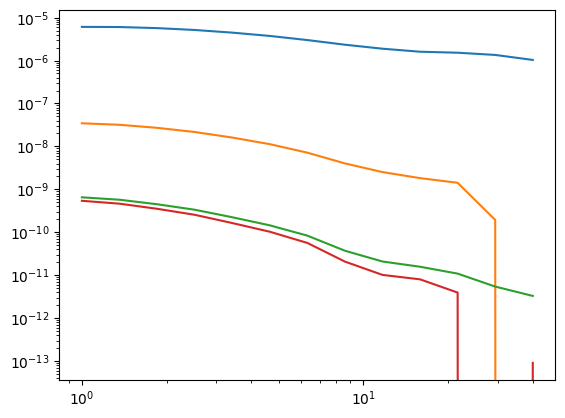

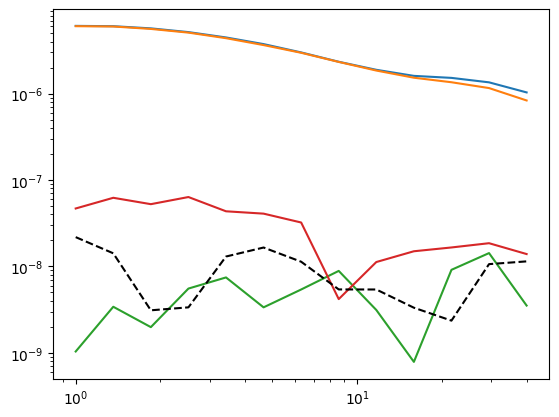

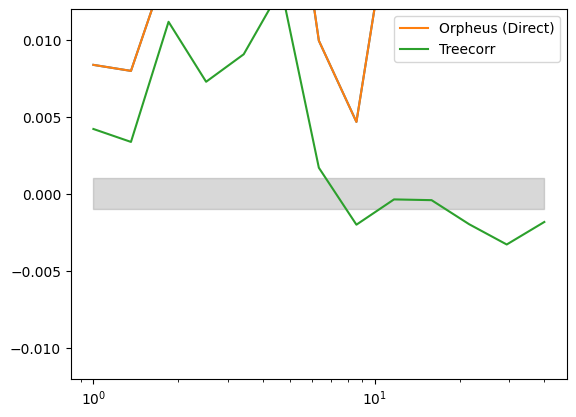

In [14]:
plt.loglog(direct.radii, mapn[0][:,0,1])
plt.loglog(direct.radii, mapn[0][:,0,2])
plt.loglog(direct.radii, mapn[0][:,0,3])
plt.loglog(direct.radii, mapn[0][:,0,3]-3*mapn[0][:,0,1]**2)
plt.show()

plt.loglog(direct.radii, mapn[0][:,0,1])
plt.loglog(direct.radii, map2s_fromnpcf[0,0])
plt.loglog(direct.radii, np.abs(map2s_fromnpcf[1,0]))
plt.loglog(direct.radii, np.abs(map2s_fromnpcf[2,0]))
plt.loglog(direct.radii, np.abs(map2s_fromnpcf[3,0]),"k--")
plt.show()

plt.semilogx(direct.radii, mapn[0][:,0,1]/map2s_fromnpcf[0,0]-1)
plt.semilogx(direct.radii, mapn[0][:,1,1]/map2s_fromnpcf[0,0]-1, label="Orpheus (Direct)")
#plt.semilogx(direct.radii, mapn[0][:,2,1]/map2s_fromnpcf[0,0]-1)
#plt.semilogx(direct.radii, mapn[0][:,3,1]/map2s_fromnpcf[0,0]-1)
#plt.semilogx(direct.radii, maps_directmap["Meas"]['Map_2'][0]/map2s_fromnpcf[0,0]-1, label="Directmap")
#plt.semilogx(direct.radii, maps_directmap_invshot["Meas"]['Map_2'][0]/map2s_fromnpcf[0,0]-1, label="Directmap (InvShot)")

plt.semilogx(direct.radii, treecorr_map2[0]/map2s_fromnpcf[0,0]-1, label="Treecorr")
plt.fill_between(x=direct.radii,y1=-0.001,y2=0.001,color="grey",alpha=0.3)
#plt.ylim(-0.12,0.12)
plt.ylim(-0.012,0.012)
plt.legend()
plt.show()

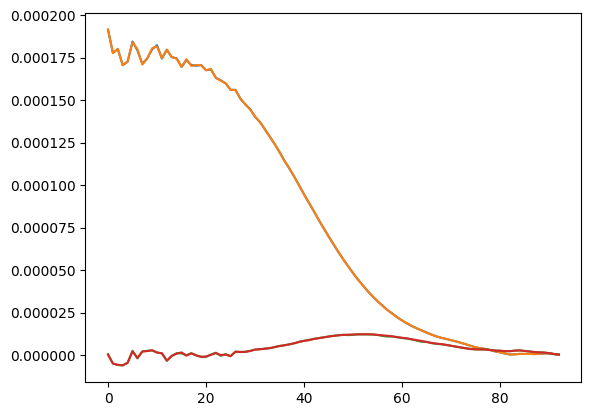

(-0.012, 0.012)

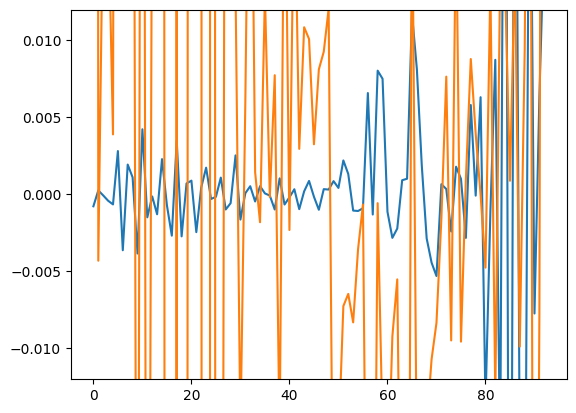

In [15]:
plt.plot(second.xip[0].real)
plt.plot(treecorr_second.xip)
plt.plot(second.xim[0].real)
plt.plot(treecorr_second.xim)
plt.show()

plt.plot(second.xip[0].real/treecorr_second.xip-1)
plt.plot(second.xim[0].real/treecorr_second.xim-1)
plt.ylim(-0.012,0.012)

(array([1164855.,       0.,       0.,       0.,       0., 1145511.,
              0.,       0.,       0.,  760435.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

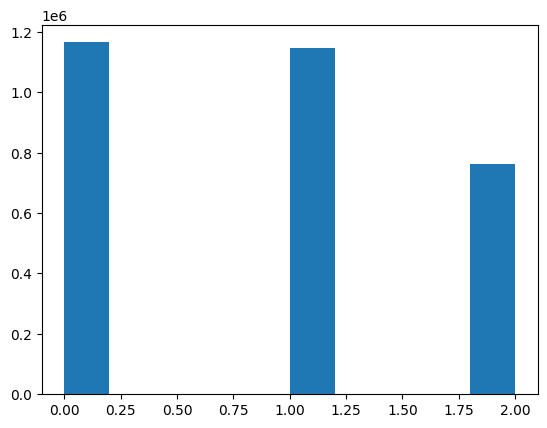

In [16]:
zbins = (slicscat['z_photometric']/0.35).astype(int).data
zbins[zbins>2] = 2
plt.hist(zbins)

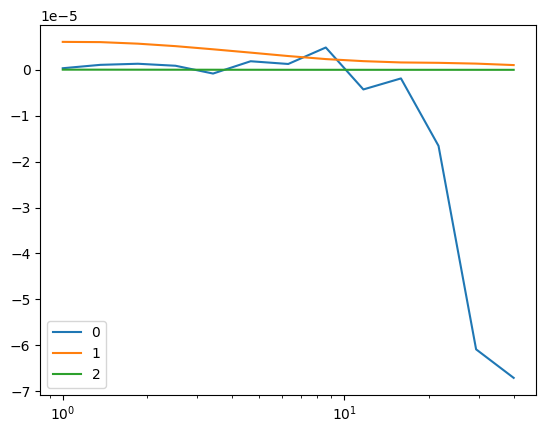

IndexError: index 7 is out of bounds for axis 2 with size 7

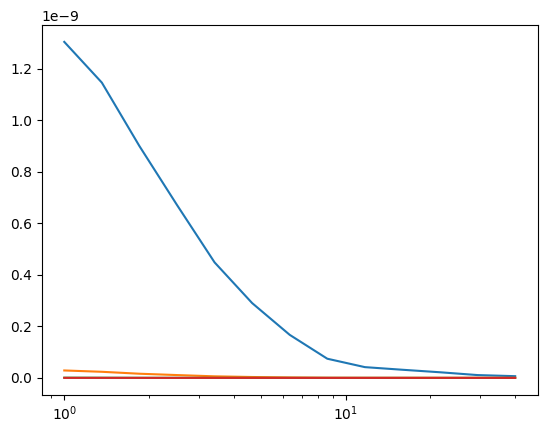

In [17]:

zs =["0", "1", "2"]
for i in range(3):
    plt.semilogx(direct.radii, mapn[0][:,0,i], label=zs[i])
plt.legend()
plt.show()
zs = ["00", "01", "02", "11", "12", "22"]
for i in range(3,9):
    plt.semilogx(direct.radii, 2*mapn[0][:,0,i], label=zs[i-3])
plt.semilogx(direct.radii, maps_directmap_invshot["Meas"]['Map_2'][0], "k--")
plt.legend()
plt.show()
zs = ["000", "001", "002", "011", "012", "022", "111", "112", "122", "222"]
for i in range(9,19):
    plt.semilogx(direct.radii, mapn[0][:,0,i], label=zs[i-9])
plt.legend()
plt.show()

zs = ["0000", "0001", "0002", "0011", "0012", "0022", "0111", "0112", "0122", "0222",
      "1111", "1112", "1122", "1222", "2222"]
for i in range(19,34):
    plt.semilogx(direct.radii, mapn[0][:,0,i], label=zs[i-19])
plt.legend()
plt.show()

In [18]:
map2s_fromnpcf = second.computeMap2(direct.radii)
mapn[0].shape

(13, 5, 7)

IndexError: index 1 is out of bounds for axis 1 with size 1

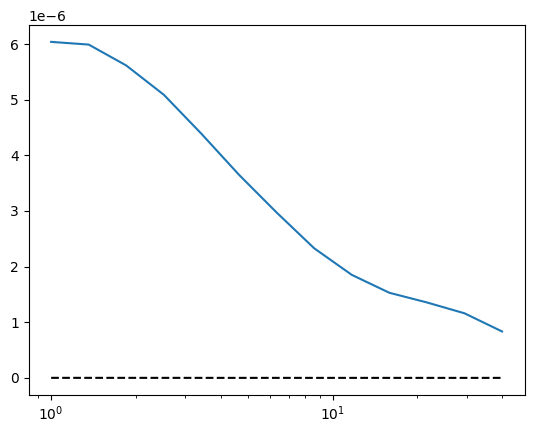

In [19]:
sortedind = direct._nzcombis_order(1, shapecat.nbinsz, True) 
for i in range(shapecat.nbinsz):
    for j in range(shapecat.nbinsz):
        if i==j:fac=1
        else:fac=1
        if i<=j:
            plt.semilogx(direct.radii, map2s_fromnpcf[0,i*shapecat.nbinsz+j],label="z%i z%i"%(i,j))
            plt.semilogx(direct.radii, mapn[0][:,0,sortedind],"k--",label="z%i z%i"%(i,j))
            #if i==0 and j==0:
            #    plt.semilogx(direct.radii, frommaps,"k:",label="z%i z%i"%(i,j))
            #    plt.semilogx(direct.radii, frommaps_nosubs,"k-.",label="z%i z%i"%(i,j))
            sortedind += 1
    
    plt.legend()
    plt.show()

In [9]:
direct.radii[5]

4.650771435192658

In [10]:
second.tree_redges

array([2.e-02, 5.e+00, 1.e+01, 2.e+01, 4.e+01, 2.e+02])

In [11]:
direct._nzcombis_order(2, 4, True)

10

In [12]:
mapn[0].shape

(13, 5, 69)

In [13]:
[direct._nzcombis_order(nbinsz=shapecat.nbinsz,order=i,dotomo=True) for i in range(1,direct.order_max+1)]

[4, 10, 20, 35]

In [14]:
direct._nzcombis_tot(nbinsz=shapecat.nbinsz,dotomo=True)

69

In [15]:
from math import factorial
factorial(12)/1e9

0.4790016

In [26]:
direct = orpheus.Direct_MapnEqual(order_max=4, Rmin=1., Rmax=40., binsize=0.3,nthreads=nthreads, 
                                  filter_form="C02", frac_covs=frac_covs,
                                  accuracies=1., method="Discrete", ap_weights="Identity")
counts, covs, Msn, Sn, Mapn, Mapn_var    = direct.getmap(5, shapecat)

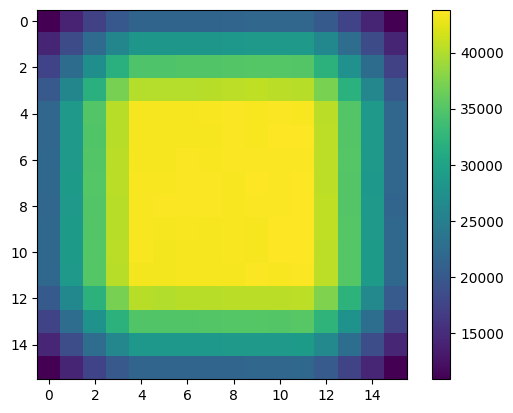

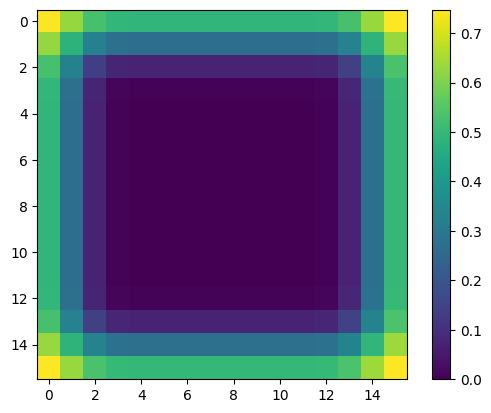

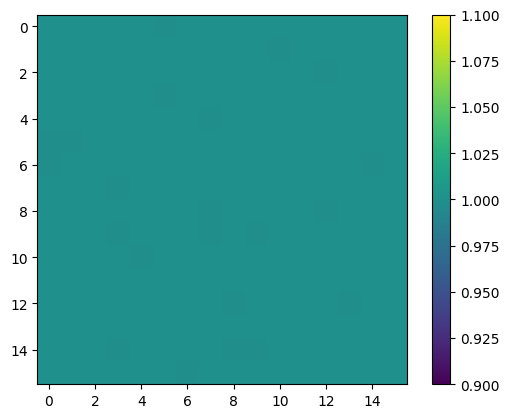

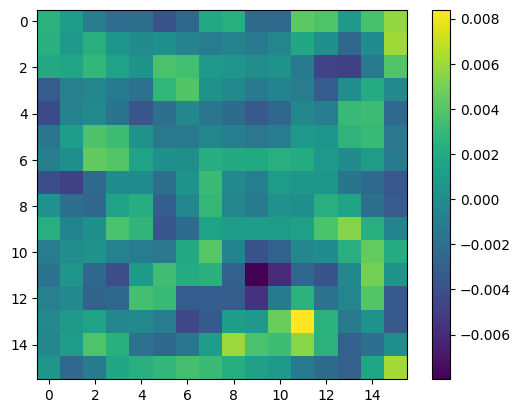

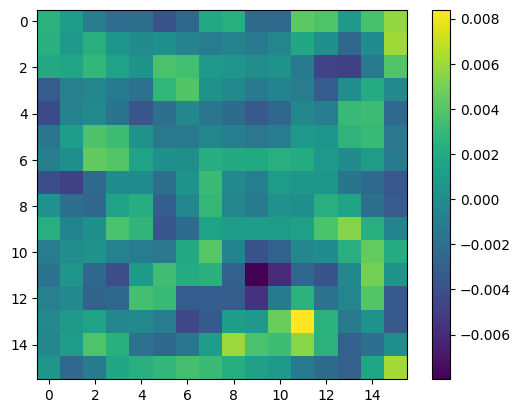

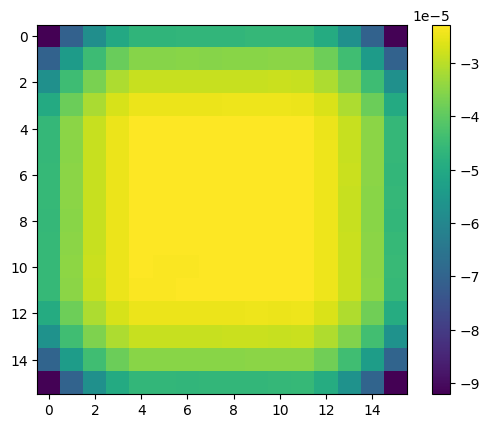

In [13]:
elbinz = 11
order = 0
plt.imshow(counts[elbinz,2])
plt.colorbar()
plt.show()

plt.imshow(covs[1])
plt.colorbar()
plt.show()

plt.imshow(Sn[elbinz,order])
plt.colorbar()
plt.show()


plt.imshow(Msn[elbinz,order])
plt.colorbar()
plt.show()

plt.imshow(Mapn[elbinz,order])
plt.colorbar()
plt.show()

plt.imshow(Mapn_var[elbinz,order])
plt.colorbar()
plt.show()

In [47]:
%%time
frommaps2 = np.zeros(direct.nbinsr)
frommaps3 = np.zeros(direct.nbinsr)
dirmaps_nosubs = np.zeros((direct.order_max+1,direct.nbinsr))
dirmaps = np.zeros((direct.order_max+1,direct.nbinsr))

elbinz=11
for elR in range(direct.nbinsr):
    print(elR)
    counts, covs, Msn, Sn, Mapn, Mapn_var  = direct.getmap(elR, shapecat)
    #nom = np.sum(Msn[elbinz,0]**2-Msn[elbinz,1])
    #denom = np.sum(Sn[elbinz,0]**2-Sn[elbinz,1])
    nom2 = Msn[elbinz,0]**2-Msn[elbinz,1]
    denom2 = Sn[elbinz,0]**2-Sn[elbinz,1]
    nom3 = Msn[elbinz,0]**3-3*Msn[elbinz,1]*Msn[elbinz,0]+2*Msn[elbinz,2]
    denom3 = Sn[elbinz,0]**3-3*Sn[elbinz,1]*Sn[elbinz,0]+2*Sn[elbinz,2]
    frommaps2[elR] = np.mean(nom2/denom2)
    frommaps3[elR] = np.mean(nom3/denom3)
    for order in range(direct.order_max):
        dirmaps[order,elR] = np.mean(Mapn[elbinz,order])
        dirmaps_nosubs[order,elR] = np.mean((Msn[elbinz,0]/Sn[elbinz,0])**(order+1))

0
1
2
3
4
5
6
7
8
9
10
11
12
CPU times: user 4min 24s, sys: 1.06 s, total: 4min 25s
Wall time: 10.3 s


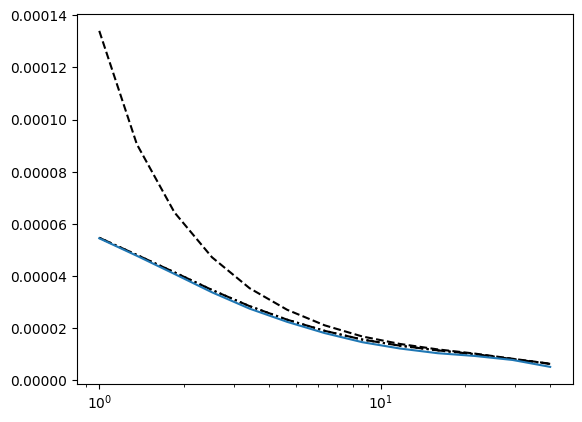

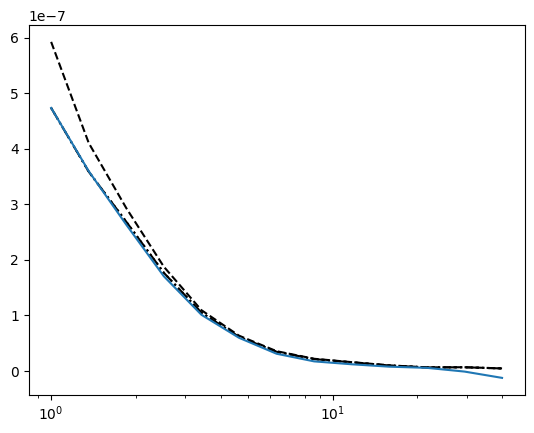

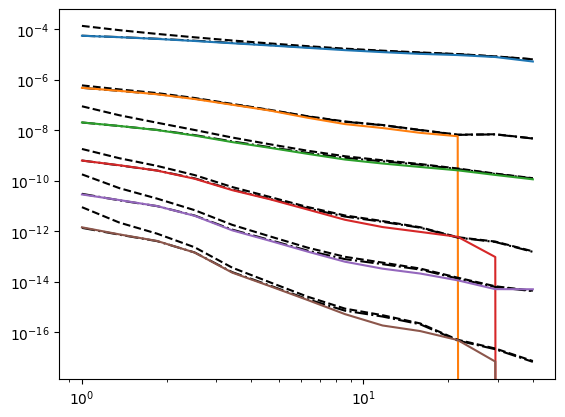

In [50]:
plt.semilogx(direct.radii, frommaps2,"k:")
plt.semilogx(direct.radii, dirmaps_nosubs[1],"k--")
plt.semilogx(direct.radii, dirmaps[1],"k-.")
plt.semilogx(direct.radii, mapn[0][:,0,direct.genzcombi(shapecat.nbinsz,[elbinz,elbinz])])
#plt.semilogx(direct.radii, map2s_fromnpcf[0,elbinz*shapecat.nbinsz+elbinz],label="z%i z%i"%(i,j))
plt.show()

plt.semilogx(direct.radii, frommaps3,"k:")
plt.semilogx(direct.radii, dirmaps_nosubs[2],"k--")
plt.semilogx(direct.radii, dirmaps[2],"k-.")
plt.semilogx(direct.radii, mapn[0][:,0,direct.genzcombi(shapecat.nbinsz,[elbinz,elbinz,elbinz])])
plt.show()

for order in range(1,direct.order_max):
    plt.semilogx(direct.radii, dirmaps_nosubs[order],"k--")
    plt.semilogx(direct.radii, dirmaps[order],"k-.")
    plt.loglog(direct.radii, mapn[0][:,0,direct.genzcombi(shapecat.nbinsz,[elbinz]*(order+1))])
plt.show()

In [39]:
[elbinz]*(order+1)

[11, 11, 11, 11, 11, 11, 11]

In [15]:
mapn[0].shape

(13, 5, 50387)

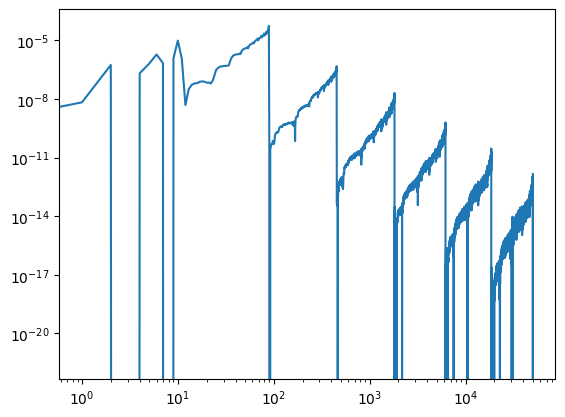

In [21]:
plt.loglog(mapn[0][0,0,:])

In [99]:
direct.genzcombi(shapecat.nbinsz,[elbinz,elbinz,elbinz,elbinz])

384

In [26]:
13*5*50387*48/1e9

0.15720744

In [22]:
thisr

array([2.10636628e-02, 2.32608823e-02, 2.56741965e-02, 2.83399480e-02,
       3.13088159e-02, 3.45512929e-02, 3.81452968e-02, 4.21077581e-02,
       4.65156854e-02, 5.13485375e-02, 5.66780092e-02, 6.26068208e-02,
       6.91278637e-02, 7.63135609e-02, 8.42505085e-02, 9.30175470e-02,
       1.02705954e-01, 1.13392387e-01, 1.25208682e-01, 1.38231506e-01,
       1.52632226e-01, 1.68520700e-01, 1.86066525e-01, 2.05431972e-01,
       2.26815519e-01, 2.50425757e-01, 2.76491163e-01, 3.05295004e-01,
       3.37079428e-01, 3.72162320e-01, 4.10918872e-01, 4.53681183e-01,
       5.00913737e-01, 5.53087851e-01, 6.10649311e-01, 6.74220746e-01,
       7.44396052e-01, 8.21901304e-01, 9.07462431e-01, 1.00194796e+00,
       1.10623198e+00, 1.22141658e+00, 1.34857702e+00, 1.48896977e+00,
       1.64396136e+00, 1.81511896e+00, 2.00405742e+00, 2.21271839e+00,
       2.44306141e+00, 2.69740170e+00, 2.97821353e+00, 3.28828334e+00,
       3.63060071e+00, 4.00856797e+00, 4.42587739e+00, 4.88662373e+00,
      

In [20]:
import pickle

def pickle_load(filename):

    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data
    
fbase_save = "/vol/euclidraid4/data/lporth/HigherOrderLensing/FourthOrder/FourthOrderShear/data/"
twopt = pickle_load(fbase_save+"xipm_convergencetest_orpheusvstc.pickle")


TcBrute: Walltime 18.551 min / CPU time 14.755h
OrBrute: Walltime 57.014 min / CPU time 37.318h
2.0 0.2 30.483957958000246
2.0 0.1 59.231363653962035
2.0 0.05 192.32602733297972
2.0 0.02 856.1342493969714
2.0 0.01 2795.2171382579836


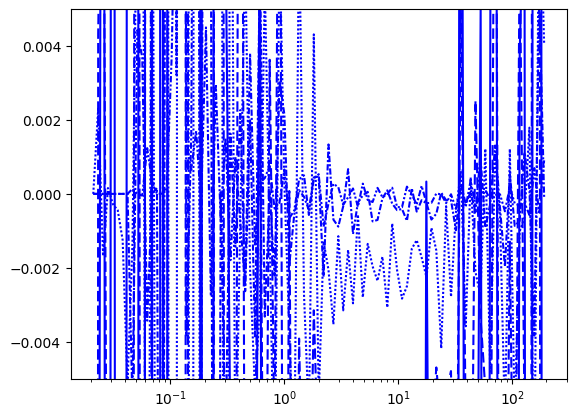

1.0 0.2 46.1656114779762
1.0 0.1 38.74120009201579
1.0 0.05 147.57490641000913
1.0 0.02 814.4778502600384
1.0 0.01 2802.5357021350064


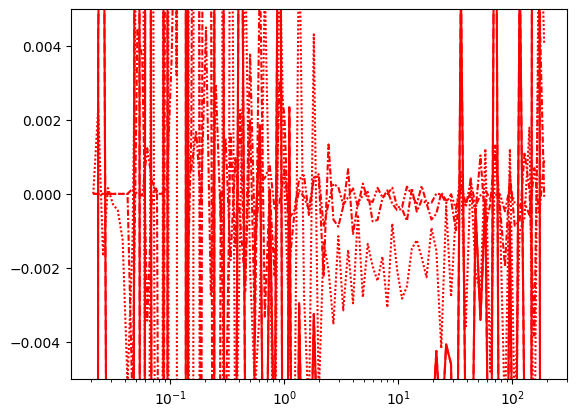

0.5 0.2 128.38143418700201
0.5 0.1 123.13078454899369
0.5 0.05 145.51823260000674
0.5 0.02 821.8437073859968
0.5 0.01 2837.2211577040143


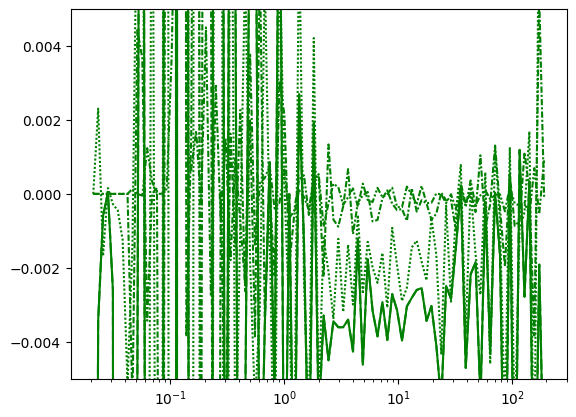

0.2 0.2 442.41052418301115
0.2 0.1 437.21336558501935
0.2 0.05 437.7164800799801
0.2 0.02 818.8234805419925
0.2 0.01 2807.057824687974


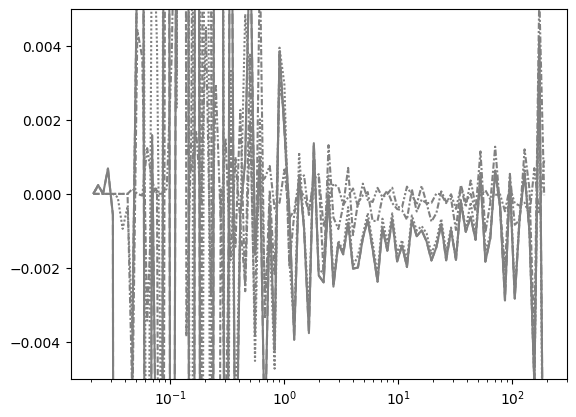

0.1 0.2 975.8176895219949
0.1 0.1 970.6916935400222
0.1 0.05 968.0142762670293
0.1 0.02 1414.143756126985
0.1 0.01 2842.2105245799758


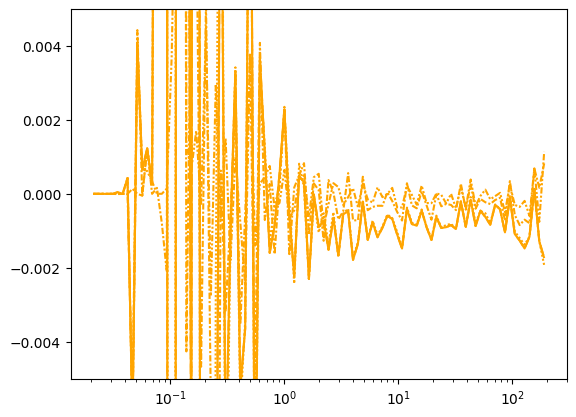

0.05 0.2 1880.769865246024
0.05 0.1 1889.3009623070247
0.05 0.05 1889.1489228460123
0.05 0.02 2250.9100298460107
0.05 0.01 4298.912114783016


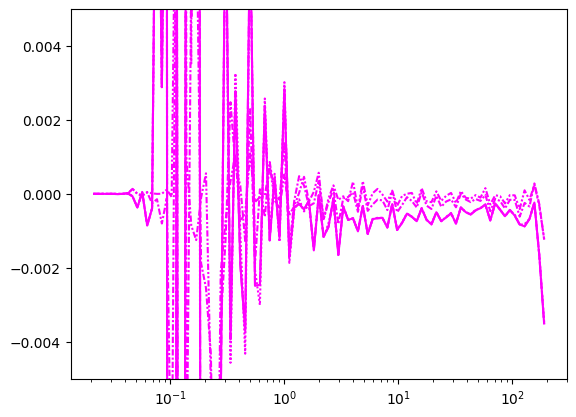

0.02 0.2 3405.3967464109883
0.02 0.1 3404.0428456559894
0.02 0.05 3433.328048194002
0.02 0.02 3744.0377789380145
0.02 0.01 5686.100695753994


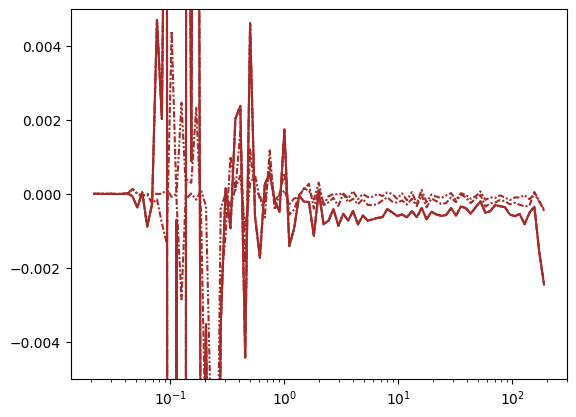

4 0.5 15598.445869918
4 1.0 706.119477489
4 2.0 60.39357203100002
4 4.0 31.486923326000003


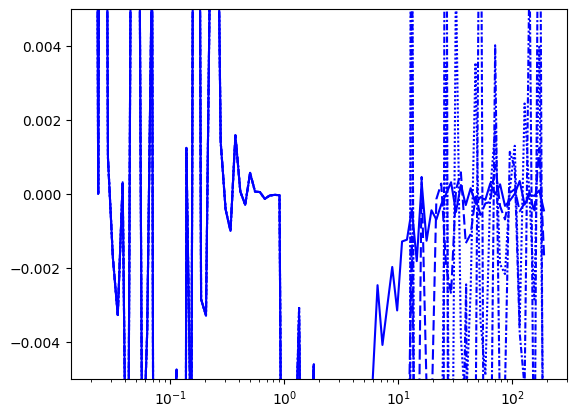

7 0.5 16652.019345458
7 1.0 769.4285271539993
7 2.0 79.54326353099896
7 4.0 51.21294862200011


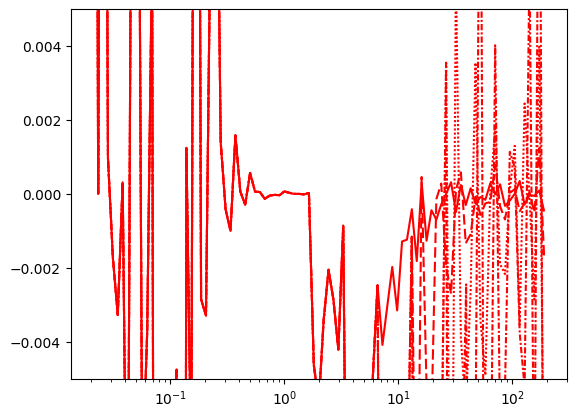

10 0.5 13088.32932230401
10 1.0 765.9661569820018
10 2.0 106.41064226599701
10 4.0 81.38070969800174


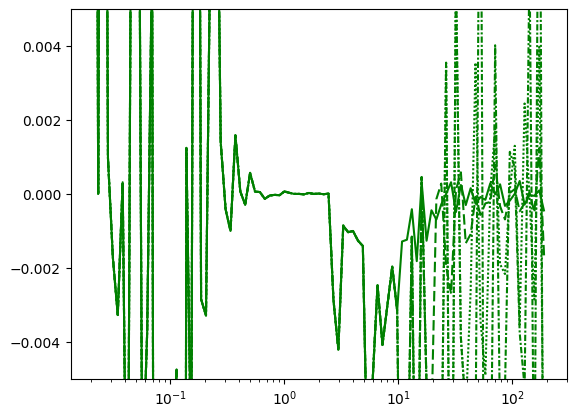

15 0.5 14634.965321924014
15 1.0 805.7273388759932
15 2.0 163.66939748400182
15 4.0 136.24143832700793


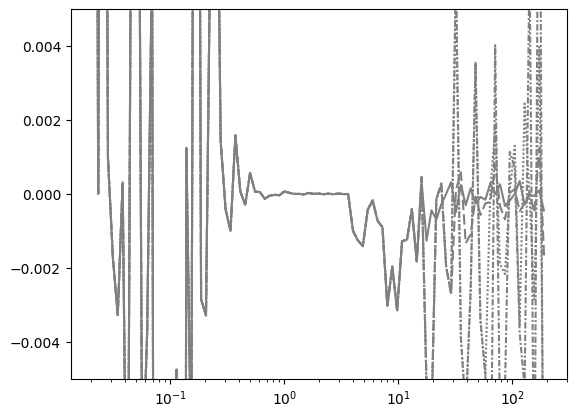

20 0.5 15483.369513829006
20 1.0 950.3092711039935
20 2.0 254.63879911601543
20 4.0 214.63854232401354


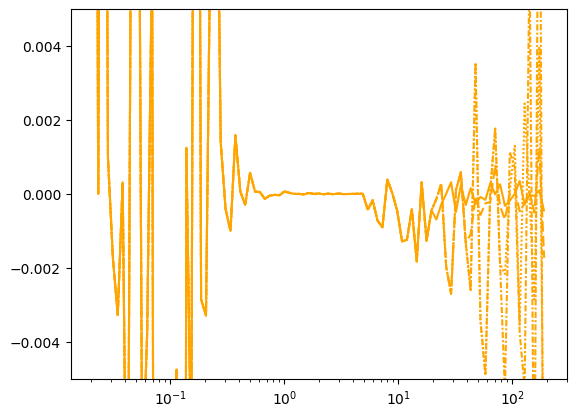

30 0.5 16401.66372059399
30 1.0 1275.854345631
30 2.0 486.32447287699324
30 4.0 405.83792305900715


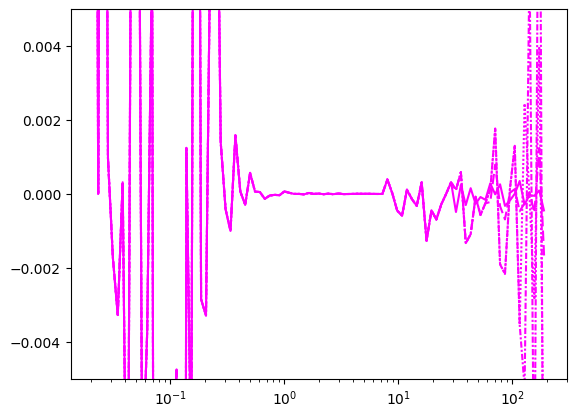

50 0.5 17630.398503563018
50 1.0 2346.678192843974
50 2.0 1217.717499136983
50 4.0 1090.564390626998


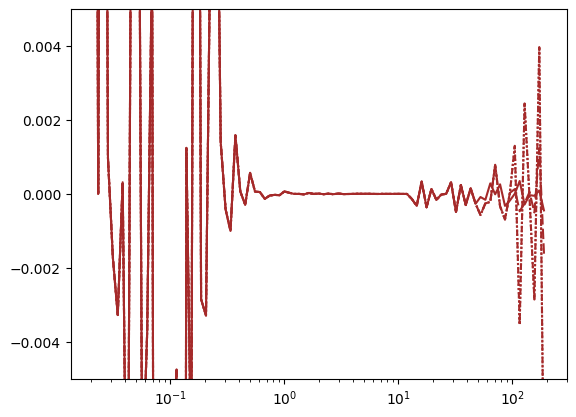

/users/lporth/anaconda3/envs/orpheus_devel/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/users/lporth/anaconda3/envs/orpheus_devel/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-0.012, 0.012)

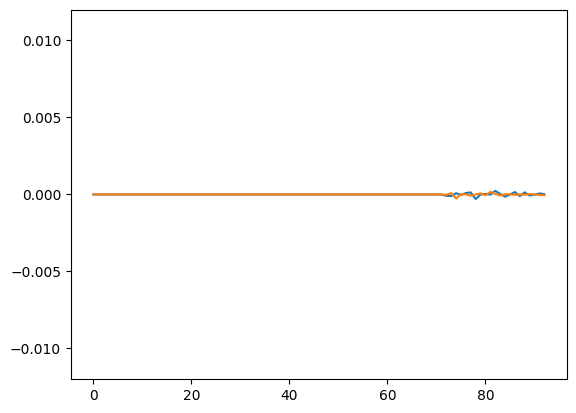

In [21]:
print("TcBrute: Walltime %.3f min / CPU time %.3fh"%(
    twopt["tcbrute"]["time_wall"]/60,twopt["tcbrute"]["time_CPU"]/3600))
print("OrBrute: Walltime %.3f min / CPU time %.3fh"%(
    twopt["orphbrute"]["time_wall"]/60,twopt["orphbrute"]["time_CPU"]/3600))
"""
for method in ["tc","orph"]:
    for var1 in twopt[method].keys():
        nextdat = np.zeros((2,len(twopt[method][var1].keys())))
        for elv2, var2 in enumerate(twopt[method][var1].keys()):
            nextdat[0,elv2] = twopt[method][var1][var2]["time_wall"]
            nextdat[1,elv2] = twopt[method][var1][var2]["time_CPU"]
        plt.semilogy(nextdat[1],label="%s %.3f"%(method,var1))
            #print(method,var1,var2)
            #print("Walltime %.3f sec / CPU time %.3f min"%(
            #    twopt[method][var1][var2]["time_wall"],twopt[method][var1][var2]["time_CPU"]/60))
    plt.axhline(y=twopt["tcbrute"]["time_CPU"],color="k",ls="--")
    plt.legend()
    plt.show()
"""

from collections import OrderedDict

linestyles = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 2))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 1, 1, 1))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 1, 1, 1, 1, 1))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])
colors = ["blue", "red", "green", "grey", "orange", "magenta", "brown"]
ls = ["solid", "dashed", "dotted", "dashdotted", "dashdotdotted"]


stat = "xim"
shuffle = "com" # "com""poissshuffle"
dc = "nodc"

for elv1,var1 in enumerate(twopt["tc"].keys()):
    for elv2, var2 in enumerate(twopt["tc"][var1].keys()):
        print(var1, var2, twopt["tc"][var1][var2]["time_CPU"])
        thisr = twopt["tc"][var1][var2]["meanr"]
        thisls = linestyles[ls[elv2]]
        thiscol = colors[elv1]
        plt.semilogx(thisr,twopt["tc"][var1][var2][stat].real/twopt["tcbrute"][stat].real-1,
                     color=thiscol,ls=thisls)
    plt.ylim(-0.005,0.005)
    plt.show()
    
for elv1,var1 in enumerate(twopt["orph"][shuffle][dc].keys()):
    for elv2, var2 in enumerate(list(twopt["orph"][shuffle][dc][var1].keys())[::-1]):
        print(var1, var2, twopt["orph"][shuffle][dc][var1][var2]["time_CPU"])
        thisr = twopt["orph"][shuffle][dc][var1][var2]["meanr"]
        thisls = linestyles[ls[elv2]]
        thiscol = colors[elv1]
        plt.semilogx(thisr,twopt["orph"][shuffle][dc][var1][var2][stat][0].real/twopt["tcbrute"][stat].real-1,
                     color=thiscol,ls=thisls)
    plt.ylim(-0.005,0.005)
    plt.show()


plt.plot(twopt["orphbrute"]["xip"][0]/twopt["tcbrute"]["xip"].real-1)
plt.plot(twopt["orphbrute"]["xim"][0]/twopt["tcbrute"]["xim"].real-1)
#plt.plot(second.xip[0].real/twopt["tcbrute"]["xim"].real-1)
plt.ylim(-0.012,0.012)

In [662]:
#twopt[method][var1][var2].keys()
list(twopt["orph"][shuffle][dc][var1].keys())[::-1]

[0.5, 1.0, 2.0, 4.0]

In [14]:
second.norm/twopt["tcbrute"]["npairs"]

array([[1.00083403, 1.        , 1.00056937, 1.00031294, 1.00037665,
        1.00010116, 1.00008393, 1.00027728, 1.0001134 , 1.00036977,
        1.00015343, 1.0000934 , 1.00015469, 1.00023329, 1.00006899,
        1.0000999 , 1.00011596, 1.00010488, 1.00009459, 1.00007095,
        1.00003693, 1.00007387, 1.00006738, 1.00004956, 1.00002637,
        1.00003919, 1.00005316, 1.00003963, 1.00003469, 1.00002843,
        1.00002482, 1.00002213, 1.00002208, 1.0000149 , 1.00001653,
        1.00001546, 1.00000979, 1.00001405, 1.00001272, 1.00001068,
        1.00000856, 1.00000835, 1.00000753, 1.0000064 , 1.00000681,
        1.00000525, 1.00000495, 1.00000502, 1.00000373, 1.00018713,
        0.99989526, 0.99782004, 1.00183578, 0.99809146, 1.00136992,
        1.00021834, 0.99965075, 0.99859819, 0.98469485, 1.01387178,
        0.98496379, 1.01135502, 1.00019546, 0.99342265, 0.9904544 ,
        0.96575642, 1.04037438, 0.95367277, 1.03721637, 0.99101187,
        0.98523301, 0.98480072, 0.95382206, 1.05

NameError: name 'treecorr_second' is not defined

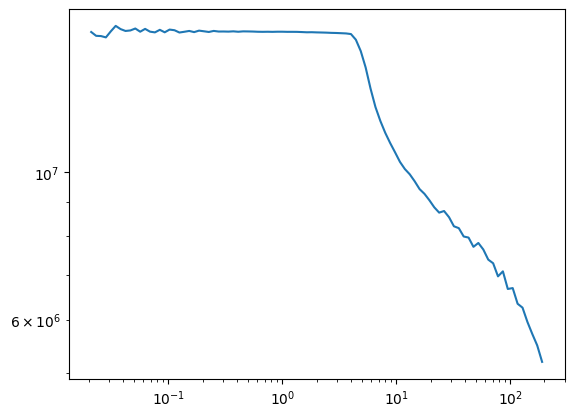

In [15]:
plt.loglog(second.bin_centers_mean, second.norm[0]/second.bin_centers_mean**2)
plt.loglog(treecorr_second.meanr, treecorr_second.npairs/treecorr_second.meanr**2)

In [667]:
odat1 = pickle_load(fbase_save+"xipm_convergencetest_orpheusdc_relpixsize100_maxpixsize0.250.pickle")
odat2 = pickle_load(fbase_save+"xipm_convergencetest_orpheusdcpoissshuffle_relpixsize20_maxpixsize4.000.pickle")
odat3 = pickle_load(fbase_save+"xipm_convergencetest_orpheusnodc_relpixsize10_maxpixsize0.500.pickle")


tdat1 = pickle_load(fbase_save+"xipm_convergencetest_tc_binslop0.100_angslop0.100.pickle")
tdat2 = pickle_load(fbase_save+"xipm_convergencetest_tc_binslop0.000_angslop0.000.pickle")

FileNotFoundError: [Errno 2] No such file or directory: '/vol/euclidraid4/data/lporth/HigherOrderLensing/FourthOrder/FourthOrderShear/data/xipm_convergencetest_orpheusdcpoissshuffle_relpixsize20_maxpixsize4.000.pickle'

3420.866563796997 12.261281490325928 29.884603261947632


(134344.36100838397, 361.64008219799143, 1414.143756126985)

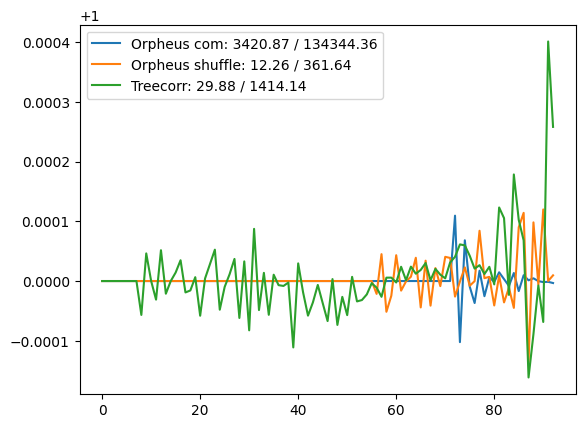

In [665]:
plt.plot(odat1["npairs"][0]/tdat2["npairs"]/2,
         label="Orpheus com: %.2f / %.2f"%(odat1["time_wall"],odat1["time_CPU"]))
plt.plot(odat2["npairs"][0]/tdat2["npairs"]/2,
         label="Orpheus shuffle: %.2f / %.2f"%(odat2["time_wall"],odat2["time_CPU"]))
plt.plot(tdat1["npairs"]/tdat2["npairs"],
         label="Treecorr: %.2f / %.2f"%(tdat1["time_wall"],tdat1["time_CPU"]))
plt.legend()
print(odat1["time_wall"],odat2["time_wall"],tdat1["time_wall"])
odat1["time_CPU"],odat2["time_CPU"],tdat1["time_CPU"]

1102.8821327260011
145.51823260000674
53117.89960719098


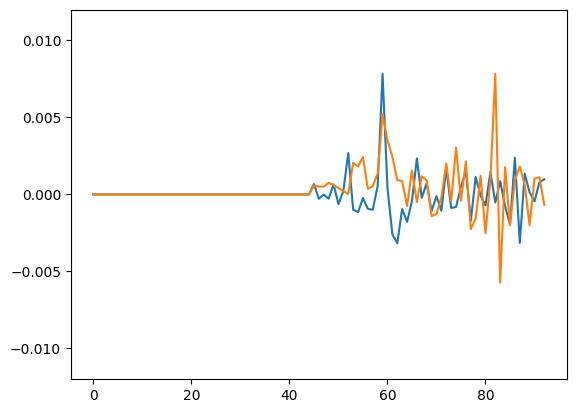

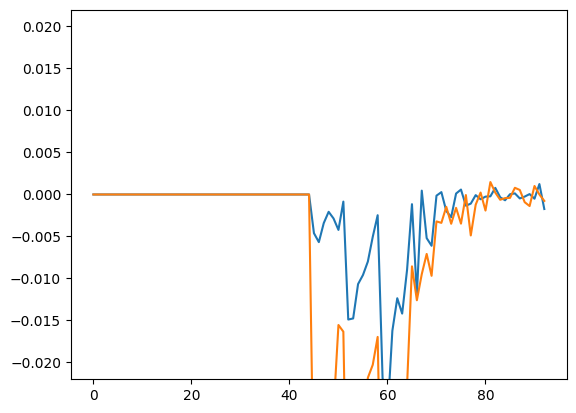

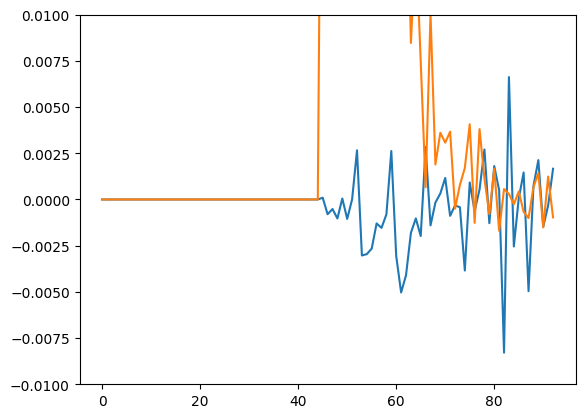

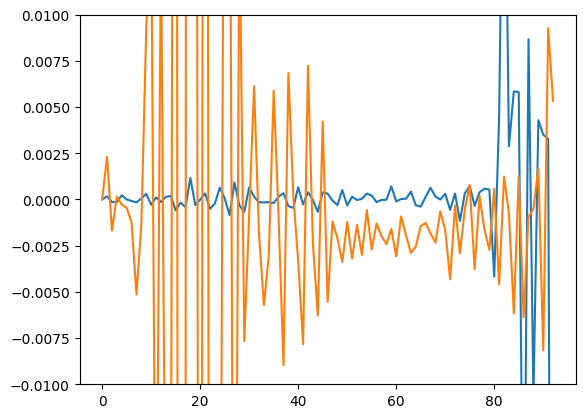

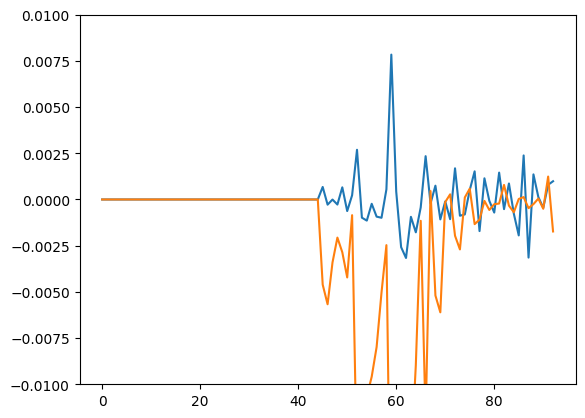

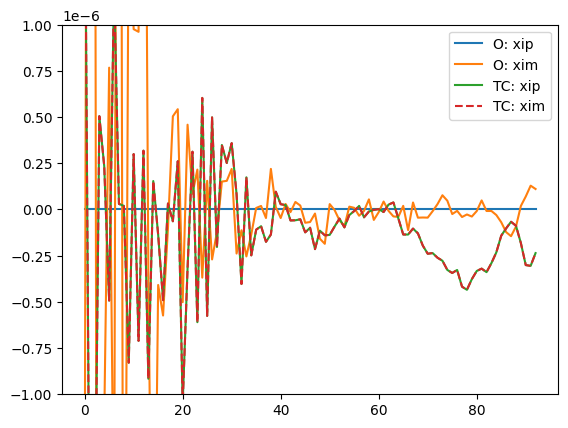

In [412]:
# plt.plot(odat["xim"][0])
print(odat1["time_CPU"])
print(tdat1["time_CPU"])
print(tdat2["time_CPU"])

plt.plot(odat1["xip"][0].real/tdat2["xip"].real-1)
plt.plot(odat2["xip"][0].real/tdat2["xip"].real-1)
plt.ylim(-0.012,0.012)
plt.show()
plt.plot(odat1["xim"][0].real/tdat2["xim"].real-1)
plt.plot(odat2["xim"][0].real/tdat2["xim"].real-1)
plt.ylim(-0.022,0.022)
plt.show()


plt.plot(odat1["xip"][0].real/odat2["xip"][0].real-1,)
plt.plot(odat1["xim"][0].real/odat2["xim"][0].real-1)
plt.ylim(-0.01,0.01)
plt.show()
plt.plot(tdat1["xip"].real/tdat2["xip"].real-1)
plt.plot(tdat1["xim"].real/tdat2["xim"].real-1)
plt.ylim(-0.01,0.01)
plt.show()
plt.plot(odat1["xip"][0].real/tdat2["xip"].real-1)
plt.plot(odat1["xim"][0].real/tdat2["xim"].real-1)
plt.ylim(-0.01,0.01)
plt.show()
plt.plot(odat1["xip"][0].imag,label="O: xip")
plt.plot(odat1["xim"][0].imag,label="O: xim")
plt.plot(tdat2["xip"].imag,label="TC: xip")
plt.plot(tdat2["xim"].imag,ls="--",label="TC: xim")
plt.ylim(-1e-6,1e-6)
plt.legend()

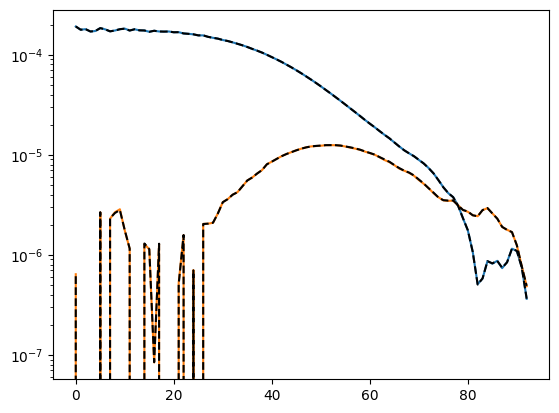

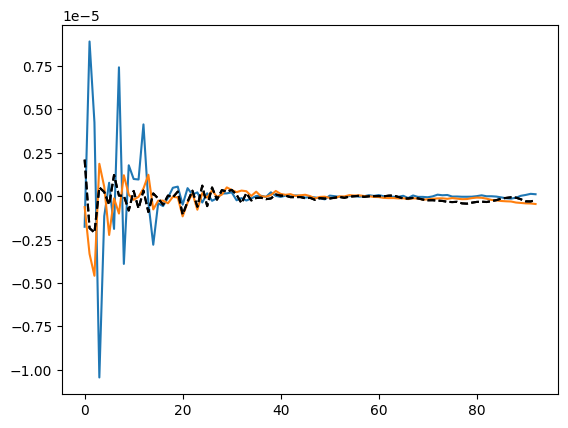

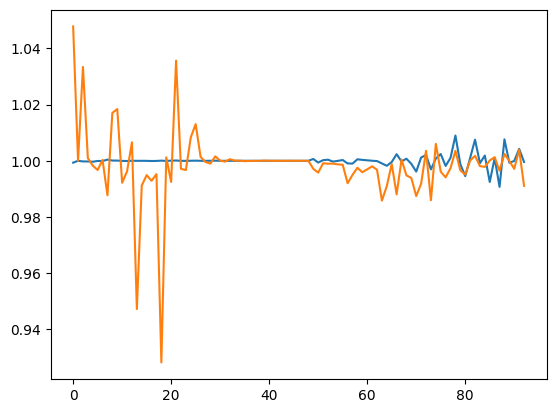

In [182]:
# With DC
plt.semilogy(second.xip[0].real)
plt.plot(second.xim[0].real)
plt.plot(twopt["tcbrute"]["xip"].real,"k--")
plt.plot(twopt["tcbrute"]["xim"].real,"k--")
plt.show()

plt.plot(second.xim[0].imag)
plt.plot(second.xip[0].imag)
plt.plot(twopt["tcbrute"]["xip"].imag,"k--")
plt.plot(twopt["tcbrute"]["xim"].imag,"k--")
plt.show()

plt.plot(second.xip[0].real/twopt["tcbrute"]["xip"].real)
plt.plot(second.xim[0].real/twopt["tcbrute"]["xim"].real)
plt.show()

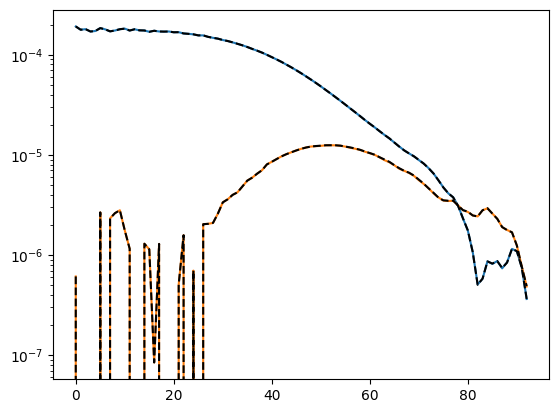

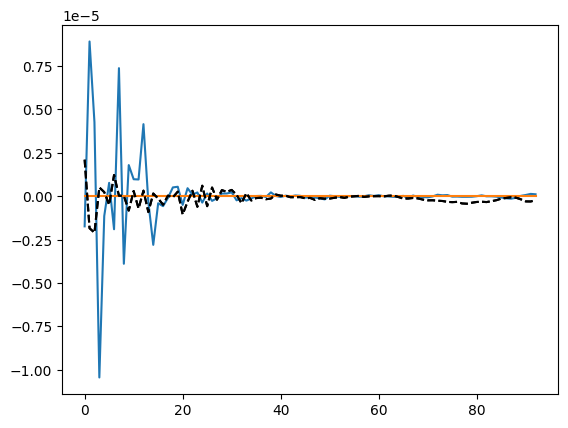

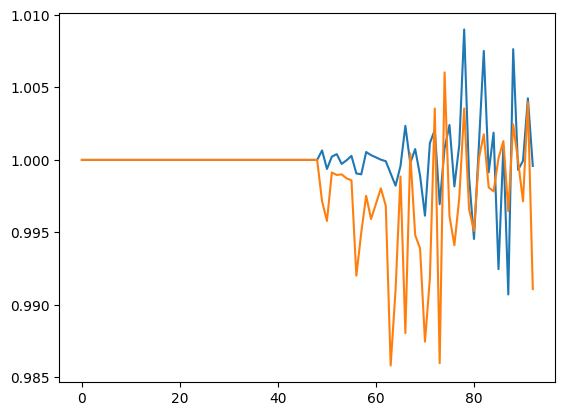

In [10]:
# No DC
plt.semilogy(second.xip[0].real)
plt.plot(second.xim[0].real)
plt.plot(twopt["tcbrute"]["xip"].real,"k--")
plt.plot(twopt["tcbrute"]["xim"].real,"k--")
plt.show()

plt.plot(second.xim[0].imag)
plt.plot(second.xip[0].imag)
plt.plot(twopt["tcbrute"]["xip"].imag,"k--")
plt.plot(twopt["tcbrute"]["xim"].imag,"k--")
plt.show()

plt.plot(second.xip[0].real/twopt["tcbrute"]["xip"].real)
plt.plot(second.xim[0].real/twopt["tcbrute"]["xim"].real)
plt.show()

In [360]:
twopt["orph"][var1][var2]["meanr"]

array([2.10636628e-02, 2.32608823e-02, 2.56741965e-02, 2.83399480e-02,
       3.13088159e-02, 3.45512929e-02, 3.81452968e-02, 4.21077581e-02,
       4.65156854e-02, 5.13485375e-02, 5.66780092e-02, 6.26068208e-02,
       6.91278637e-02, 7.63135609e-02, 8.42505085e-02, 9.30175470e-02,
       1.02705954e-01, 1.13392387e-01, 1.25208682e-01, 1.38231506e-01,
       1.52632226e-01, 1.68520700e-01, 1.86066525e-01, 2.05431972e-01,
       2.26815519e-01, 2.50425757e-01, 2.76491163e-01, 3.05295004e-01,
       3.37079428e-01, 3.72162320e-01, 4.10918872e-01, 4.53681183e-01,
       5.00913737e-01, 5.53087851e-01, 6.10649311e-01, 6.74220746e-01,
       7.44396052e-01, 8.21901304e-01, 9.07462431e-01, 1.00223020e+00,
       1.10574182e+00, 1.22197849e+00, 1.34804780e+00, 1.48937038e+00,
       1.64370420e+00, 1.81458840e+00, 2.00839603e+00, 2.20525909e+00,
       2.45262759e+00, 2.68969707e+00, 2.98324602e+00, 3.28321553e+00,
       3.62237421e+00, 4.04335531e+00, 4.39286211e+00, 4.95890888e+00,
      

In [358]:
meanr

NameError: name 'meanr' is not defined